In [25]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, MaxPool2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2

In [2]:
x = np.load('../numpy_data/images.npy')
y = np.load('../numpy_data/labels.npy')

In [3]:
## Selecting only first 20k images due to low computational power, 
## this can be removed when access to high RAM and VRAM is available with some tweaks to batch size
x = x[:20000, :, :]
y = y[:20000]

In [4]:
##Imported image is only single channel
## Making the images into 3 channels by repeating on axis to be compatible with MobileNet
x = np.repeat(x[:, :, :, np.newaxis], 3, axis=3)

In [5]:
x.shape

(20000, 79, 79, 3)

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

In [7]:
x_train.shape

(14000, 79, 79, 3)

In [8]:
img_dim = x.shape[1]

base_model = MobileNetV2(include_top = False, weights = 'imagenet', input_shape = (img_dim, img_dim, 3))

for layers in base_model.layers:
    layers.trainable = False

Metal device set to: Apple M2


2023-06-27 13:09:09.914266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-27 13:09:09.915256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 79, 79, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 40, 40, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 40, 40, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 40, 40, 32)   0           ['bn_Conv1[0][0]']               
                                                                               

                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 10, 10, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 10, 10, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 10, 10, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 10, 10, 32)  128         ['block_3_project[0][0]']        
 lization)                                                                                        
          

                                                                                                  
 block_7_expand_relu (ReLU)     (None, 5, 5, 384)    0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 5, 5, 384)   3456        ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 5, 5, 384)   1536        ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_depthwise_relu (ReLU)  (None, 5, 5, 384)    0           ['block_7_depthwise_BN[0][0]']   
          

 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 5, 5, 576)    55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 5, 5, 576)   2304        ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 5, 5, 576)    0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_depthwise (DepthwiseC  (None, 5, 5, 576)   5184        ['block_11_expand_relu[0][0]']   
 onv2D)   

 block_14_depthwise_relu (ReLU)  (None, 3, 3, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 3, 3, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 3, 3, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 3, 3, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_

In [10]:
model = Sequential()

model.add(base_model)

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = 'adam', metrics = 'accuracy', loss = 'binary_crossentropy')

In [12]:
es = EarlyStopping(monitor = 'val_loss', patience = 10)

In [15]:
model.fit(x = x_train, y = y_train, epochs = 1000, validation_data = (x_test, y_test), callbacks=es, batch_size = 64)

Epoch 1/1000
219/219 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9960

2023-06-27 13:09:52.917418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


219/219 [==============================] - 13s 59ms/step - loss: 0.0152 - accuracy: 0.9960 - val_loss: 0.0221 - val_accuracy: 0.9958
Epoch 2/1000
219/219 [==============================] - 11s 52ms/step - loss: 0.0136 - accuracy: 0.9968 - val_loss: 0.0176 - val_accuracy: 0.9970
Epoch 3/1000
219/219 [==============================] - 12s 53ms/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.0210 - val_accuracy: 0.9965
Epoch 4/1000
219/219 [==============================] - 12s 53ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 0.0153 - val_accuracy: 0.9975
Epoch 5/1000
219/219 [==============================] - 12s 53ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.0158 - val_accuracy: 0.9977
Epoch 6/1000
219/219 [==============================] - 12s 53ms/step - loss: 0.0142 - accuracy: 0.9969 - val_loss: 0.0248 - val_accuracy: 0.9975
Epoch 7/1000
219/219 [==============================] - 12s 53ms/step - loss: 0.0096 - accuracy: 0.9975 - val_loss: 0.0161 - val_accuracy

In [16]:
preds = model.predict(x_test)

2023-06-27 14:06:41.263137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 5s 20ms/step


In [20]:
preds = preds.round()

print("Accuracy:", accuracy_score(y_test, preds))
print("Classification Report:", classification_report(y_test, preds))

Accuracy: 0.9975
Classification Report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2792
           1       1.00      1.00      1.00      3208

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [21]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([2792, 3208]))

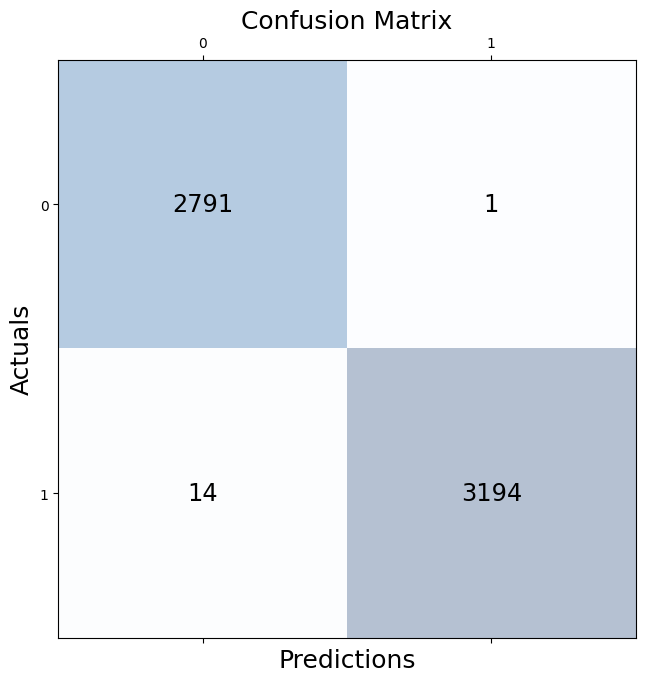

In [26]:
conf_matrix = confusion_matrix(y_test, preds)

fig, ax = plt.subplots(figsize=(7.5, 7.5))

ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [27]:
model.save('../code/mobilenet_nids.h5')